In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [2]:
alldata_df = pd.read_csv('all_stocks_5yr.csv')
test_df = alldata_df[alldata_df['date'] > '2017-02-08']
alldata_df = alldata_df[alldata_df['date'] < '2017-02-08']
alldata_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
def relative_strength_index(stock, n = 14):
    
    difference = stock['close'].diff()
    up, down = difference.copy(), difference.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rs = up.rolling(n).mean() / down.abs().rolling(n).mean()
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [4]:
def average_directional_movement_index(stock, n=14, n_ADX=14):
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= stock.index[-1]:
        UpMove = stock.loc[i + 1, 'high'] - stock.loc[i, 'high']
        DoMove = stock.loc[i, 'low'] - stock.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < stock.index[-1]:
        TR = max(stock.loc[i + 1, 'high'], stock.loc[i, 'close']) - min(stock.loc[i + 1, 'low'], stock.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX).mean())
    ADX = 100*ADX
    
    return ADX

In [5]:
def bollinger_bands(stock, n=14):
    
    MA = stock['close'].rolling(n).mean()
    MSD = stock['close'].rolling(n).std()
    bandwidth = 4 * MSD / MA * 100

    return bandwidth

In [6]:
def get_stock_indicators(stock):
    
    stock = stock.reset_index().drop(['index','Name'], axis = 1)

    #stock['dailyrange'] = ((stock['high'] - stock['low'] )/ stock['low'])*100

    #stock['dailychange'] = stock['close'].pct_change()

    #stock['sma10'] = stock.loc[:,'close'].rolling(window = 14).mean()

    stock['ema10'] = stock['close'].ewm(span = 14, adjust = False).mean()
    
    stock['rsi'] = relative_strength_index(stock,14)
    
    #stock['adx'] = average_directional_movement_index(stock,14,14)
    
    #stock['bollingerbw'] = bollinger_bands(stock,14)

    return stock

In [7]:
def principal_components(stock, ticker = 'stockname_in_parameter'):
    
    stockvalues = stock.loc[:,['close','ema10','rsi']].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
      
    stock_pca = PCA(svd_solver = 'full').fit(stock_for_PCA)

    stock_pc = PCA(svd_solver = 'full', n_components = 1).fit_transform(stock_for_PCA)
    
    print('% Variance Explained for '+ ticker + ' = {}'.format(round(stock_pca.explained_variance_ratio_[0],2)))
    
    return stock_pc.reshape(len(stock_pc))

In [8]:
def principal_components_with_fitter(stock, fitter):
   
    '''
    Fits a given stock to the PCs of another stock to see similarity.
    Returns the transformed stock wrt the PC1 of the fitter stock.
    
    '''
    
    stockvalues = stock.loc[:,['close','ema10','rsi']].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
    
    stock_pc = fitter.transform(stock_for_PCA)[:,0]
    
    return stock_pc.reshape(len(stock_pc))

In [9]:
def correlation_maximized_selection_algorithm(selected_stocks, n=5 , first_stock = 'FB'):
    
    correlations = []
    diverse_stocks = [first_stock]
    
    for i in range(n-1):
        if i==0:
            stock = selected_stocks[selected_stocks['Name'] == first_stock]
            current_stock = first_stock
        else:
            stock = selected_stocks[selected_stocks['Name'] == next_stock]
            current_stock = next_stock
        
        stock = get_stock_indicators(stock)
        #print(stock)
        stock_pc1 = principal_components(stock, current_stock)
        scaler = StandardScaler()
        stock_for_pca = scaler.fit_transform(stock.loc[:,['close','ema10','rsi']].dropna().values)


        transformed_stocks = pd.DataFrame(index = range(len(stock_pc1)), columns = [current_stock])
        transformed_stocks[current_stock] = stock_pc1

        tickers = selected_stocks['Name'].unique().tolist()

        fitter = PCA(svd_solver = 'full').fit(stock_for_pca)

        for ticker in tickers:
            stock = selected_stocks[selected_stocks['Name'] == ticker]

            stock = get_stock_indicators(stock)

            stock_pc = principal_components_with_fitter(stock, fitter)

            if len(stock_pc) != len(transformed_stocks):
                continue
            transformed_stocks[ticker] = stock_pc
        
        correlations.append(transformed_stocks.corr()[current_stock].sort_index().tolist())
        max_index, max_sum = max_sum_row(correlations)
        #print('Sum of the correlations is {}'.format(round(max_sum,2)))
        correlations[0][max_index] = -100.0
        next_stock = transformed_stocks.corr()[current_stock].index[max_index]
        if next_stock in diverse_stocks:
            print('Not adding ' + next_stock + ' again')
            continue
        diverse_stocks.append(next_stock)
        print('Next Stock added is '+next_stock)
        
    return diverse_stocks, correlations

In [10]:
def max_sum_row(mat):  
    
    idx = -1000  
    maxSum = -1000

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation > maxSum): 
            maxSum = summation  
            idx = i  
    return idx, maxSum

In [11]:
def get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr = 2.5, weights = []):
    '''
    Takes in the portfolio dataframe and Risk Free Rate. Assigns risk free rate of 2.5% by default.
    Returns the sharpe ratio.   
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = get_portfolio_return(portfolio_df, weights)
    _, portfolio_std = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
    
    sharpe_ratio = (portfolio_return - (rfr/100))/portfolio_std
    
    return sharpe_ratio

In [12]:
def get_portfolio_VAR(portfolio_df, selected_stocks_variance_df, weights, alpha = 0.05):
    ret = get_portfolio_return(portfolio_df, weights)
    
    _, stdev = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
    
    var = st.norm.ppf(1 - alpha, ret, stdev)
    
    var = 1.65*stdev
    
    return ret, stdev, var

In [13]:
def get_portfolio_return(portfolio_df, weights = []):
    '''
    Takes in the portfolio dataframe and weights. Assigns uniform weights as default.
    Returns portfolio average yearly return.
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = sum( [a*b for a,b in zip(portfolio_df['yearly returns'].tolist(), weights)] )
    
    return portfolio_return

In [14]:
def get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights = []):
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    weights = np.array(weights)
    
    cov = selected_stocks_variance_df[portfolio_df['tickers'].tolist()].loc[portfolio_df['tickers'].tolist()].values
    
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252) #252 is the number of trading days
    
    portfolio_variance = portfolio_std**2
    
    return portfolio_variance, portfolio_std

In [15]:
def monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, rfr=2.5, number_of_trials = 1000):
    results = np.zeros((len(portfolio_df)+3, number_of_trials))
    for i in range(number_of_trials):
        weights = np.random.random(len(portfolio_df))
        weights /= np.sum(weights)
        p = get_portfolio_return(portfolio_df, weights)
        _,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
        s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr, weights)
        results[0,i] = p
        results[1,i] = q
        results[2,i] = s
        for j in range(len(weights)):
            results[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results.T,columns=['returns','risk','sharpe ratio'] + [ticker for ticker in portfolio_df['tickers'].unique()])
    
    return results_df

In [16]:
def monte_carlo_portfolios_VAR(portfolio_df, selected_stocks_variance_df, number_of_trials = 1000, alpha = 0.05):
    results = np.zeros((len(portfolio_df)+3, number_of_trials))
    for i in range(number_of_trials):
        weights = np.random.random(len(portfolio_df))
        weights /= np.sum(weights)
        
        returns, stdev, var = get_portfolio_VAR(portfolio_df, selected_stocks_variance_df, weights, alpha)
        results[0,i] = returns
        results[1,i] = stdev
        results[2,i] = var
        for j in range(len(weights)):
            results[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results.T,columns=['returns','risk','var'] + [ticker for ticker in portfolio_df['tickers'].unique()])
    
    return results_df

In [17]:
def future_returns(test_df, diverse_stocks, initial_amount = 1000, weights = []):
    if len(weights) == 0:
        weights = len(diverse_stocks) * [1/len(diverse_stocks)]
    
    
    weights = np.array(weights)
    weights *= initial_amount
    
    useful_df = test_df[test_df['Name'].isin(diverse_stocks)].sort_values(['date', 'Name']).reset_index(drop = True)
    
    first_day_open = np.array(useful_df['open'].iloc[:len(weights)])
    
    portfolio_valuation = {}
    
    for date in useful_df.date.unique():
        change_on_date = np.array(useful_df.set_index('date')['close'][date]) - first_day_open
        #Value added is the percent change that day compared to the bought price multiplied by the weight
        value_added = np.divide(change_on_date, first_day_open)*weights
        value_on_date = (value_added + weights).sum()
        portfolio_valuation[date] = value_on_date
    
    return portfolio_valuation

In [18]:
'''
This block basically takes only the stocks with over 10% or 15% returns and eliminates the rest.
The 15% data is already stored in the high_returns_df dataframe, which was stored in excel previously.

'''
high_returns_df = pd.read_excel('selected_stocks_10_percent_YoY_4yr.xlsx').dropna()

tickers = high_returns_df['tickers'].tolist()

selected_stocks = alldata_df[alldata_df['Name'] == tickers[0]]
for ticker in tickers[1:]:
    selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == ticker] ] , axis = 0)
#selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == 'WYNN'] ] , axis = 0)

#This part just removes incomplete data.
for ticker in selected_stocks['Name'].unique().tolist():
    if selected_stocks['Name'].value_counts()[ticker] != 1007:
        selected_stocks = selected_stocks[selected_stocks.Name != ticker]
selected_stocks['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ACN', 'ADBE', 'ADI', 'ADM',
       'ADP', 'ADSK', 'ADS', 'AEE', 'AET', 'AFL', 'AGN', 'AIG', 'AIV',
       'AIZ', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALXN', 'AMAT', 'AMD',
       'AMGN', 'AMP', 'AMZN', 'ANDV', 'ANTM', 'AON', 'AOS', 'APD', 'APH',
       'ARE', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AYI', 'AZO', 'BAC',
       'BA', 'BBT', 'BBY', 'BDX', 'BIIB', 'BK', 'BLK', 'BLL', 'BRK.B',
       'BSX', 'CAH', 'CBOE', 'CBS', 'CB', 'CDNS', 'CELG', 'CHD', 'CHTR',
       'CINF', 'CI', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMS', 'CNC',
       'COF', 'COL', 'COO', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTSH', 'CVS', 'CXO', 'DAL', 'DFS', 'DGX', 'DG', 'DISH', 'DIS',
       'DLR', 'DLTR', 'DPS', 'DRE', 'DRI', 'DTE', 'D', 'EA', 'ECL', 'EFX',
       'EIX', 'EOG', 'EQIX', 'ESS', 'ETFC', 'EW', 'EXPE', 'EXR', 'FBHS',
       'FB', 'FDX', 'FFIV', 'FISV', 'FIS', 'FITB', 'FL', 'GD', 'GE',
       'GILD', 'GIS', 'GLW', 'GOOGL', 'GPC', 'GPN', 'GS', '

In [19]:
'''
This block calculates the covariance matrix between the selected stocks
'''
price_df = pd.DataFrame(index = range(1007), columns = selected_stocks['Name'].unique())
for ticker in selected_stocks['Name'].unique():
    price_df[ticker] = selected_stocks[selected_stocks['Name'] == ticker]['close'].reset_index(drop = True)

selected_stocks_variance_df = price_df.pct_change().cov()
selected_stocks_variance_df.head()

,AAL,AAPL,AAP,ABBV,ABC,ACN,ADBE,ADI,ADM,ADP,...,WFC,WHR,WM,WU,XEC,XEL,XLNX,XYL,ZION,ZTS
AAL,0.000545,0.000071,0.000089,0.000100,0.000074,0.000089,0.000118,0.000114,0.000086,0.000098,...,0.000097,0.000155,0.000049,0.000095,0.000073,0.000023,0.000095,0.000100,0.000127,0.000090
AAPL,0.000071,0.000231,0.000045,0.000049,0.000030,0.000055,0.000066,0.000091,0.000046,0.000052,...,0.000054,0.000067,0.000037,0.000060,0.000074,0.000018,0.000054,0.000057,0.000070,0.000056
AAP,0.000089,0.000045,0.000285,0.000075,0.000038,0.000053,0.000073,0.000068,0.000072,0.000062,...,0.000068,0.000085,0.000048,0.000068,0.000081,0.000038,0.000066,0.000070,0.000084,0.000049
ABBV,0.000100,0.000049,0.000075,0.000297,0.000085,0.000060,0.000083,0.000084,0.000077,0.000070,...,0.000076,0.000078,0.000044,0.000072,0.000088,0.000033,0.000080,0.000074,0.000087,0.000098
ABC,0.000074,0.000030,0.000038,0.000085,0.000182,0.000049,0.000048,0.000044,0.000038,0.000051,...,0.000058,0.000065,0.000026,0.000064,0.000042,0.000015,0.000041,0.000043,0.000061,0.000060


In [20]:
seed_stock = 'FB'
diverse_stocks, correlations = correlation_maximized_selection_algorithm(selected_stocks, 10, seed_stock)
diverse_stocks

% Variance Explained for FB = 0.67
Next Stock added is EXR
% Variance Explained for EXR = 0.67
Next Stock added is STZ
% Variance Explained for STZ = 0.69
Next Stock added is FISV
% Variance Explained for FISV = 0.68
Next Stock added is ORLY
% Variance Explained for ORLY = 0.67
Next Stock added is AYI
% Variance Explained for AYI = 0.67
Next Stock added is AWK
% Variance Explained for AWK = 0.67
Next Stock added is GPN
% Variance Explained for GPN = 0.67
Next Stock added is NDAQ
% Variance Explained for NDAQ = 0.67
Next Stock added is ECL


['FB', 'EXR', 'STZ', 'FISV', 'ORLY', 'AYI', 'AWK', 'GPN', 'NDAQ', 'ECL']

In [21]:
portfolio_df = high_returns_df
portfolio_df = portfolio_df[portfolio_df['tickers'].isin(diverse_stocks)].reset_index(drop = True)
portfolio_df

,tickers,yearly returns,yearly variance
0,AWK,0.171523,0.073081
1,AYI,0.377927,0.259948
2,ECL,0.139827,0.164175
3,EXR,0.206880,0.251296
4,FB,0.443738,0.279697
5,FISV,0.283830,0.116081
6,GPN,0.309154,0.179316
7,NDAQ,0.235502,0.069022
8,ORLY,0.303295,0.134876
9,STZ,0.539481,0.419498


In [22]:
p = get_portfolio_return(portfolio_df)
_,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df)
s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, 2.5)

print('Portfolio Returns: {}%'.format(round(p*100,2)))
print('Portfolio Risk: {}%'.format(round(q*100,2)))
print('Portfolio Sharpe Ratio: {}'.format(round(s,2)))

Portfolio Returns: 30.11%
Portfolio Risk: 14.15%
Portfolio Sharpe Ratio: 1.95


In [23]:
results_df = monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, 2.5, 10000)

In [24]:
results_df_var = monte_carlo_portfolios_VAR(portfolio_df, selected_stocks_variance_df, 10000, 0.05)

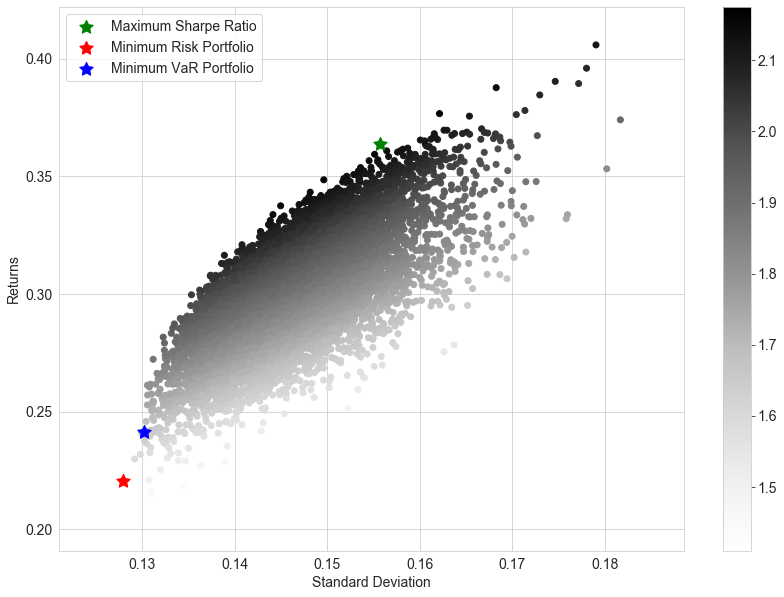

In [25]:
#Highest Sharpe Ratio Point
max_sharpe = results_df.iloc[results_df['sharpe ratio'].idxmax()]
#Minimum Risk Point
min_risk = results_df.iloc[results_df['risk'].idxmin()]
#Min VAR point
min_var = results_df_var.iloc[results_df_var['var'].idxmin()]

plt.subplots(figsize=(14,10))
plt.scatter(results_df['risk'], results_df['returns'], c = results_df['sharpe ratio'], cmap = 'Greys')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

plt.scatter(max_sharpe[1], max_sharpe[0], marker=(5,1,0),color='green',s = 200, label = 'Maximum Sharpe Ratio')

plt.scatter(min_risk[1], min_risk[0], marker=(5,1,0),color='red',s = 200, label = 'Minimum Risk Portfolio')

plt.scatter(min_var[1], min_var[0], marker=(5,1,0),color='blue',s = 200, label = 'Minimum VaR Portfolio')

plt.legend()

#plt.savefig('risk-return-FB.jpg', dpi = 500, bbox_inches = 'tight')


plt.show()

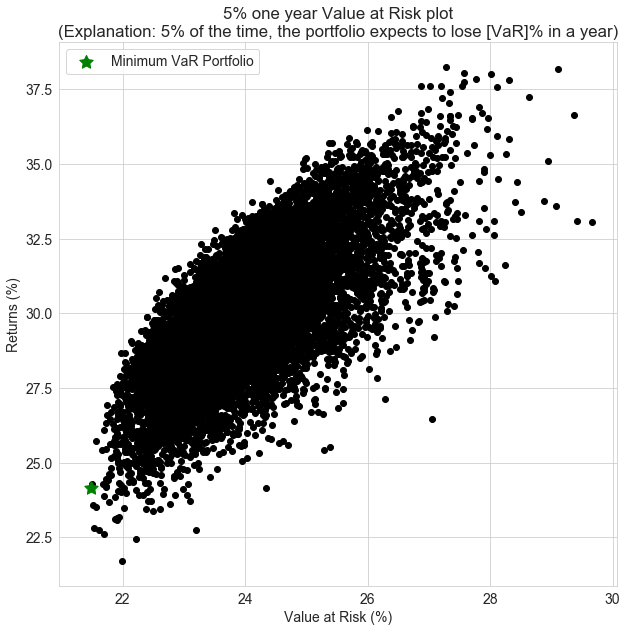

In [26]:
plt.subplots(figsize=(10,10))
plt.scatter(results_df_var['var']*100, results_df_var['returns']*100, color = 'black')
plt.xlabel('Value at Risk (%)')
plt.ylabel('Returns (%)')

plt.scatter(min_var[2]*100, min_var[0]*100, marker=(5,1,0),color='green',s = 200, label = 'Minimum VaR Portfolio')

plt.title('5% one year Value at Risk plot\n(Explanation: 5% of the time, the portfolio expects to lose [VaR]% in a year)')

plt.legend()

#plt.xlim([0.1,0.6])
#plt.ylim([0.1,0.9])

#plt.savefig('VaR-FB.jpg', dpi = 500, bbox_inches = 'tight')

plt.show()

### Markovitz Optimization

The entire mean portfolio theory optimization math can be found here (healthy individuals are advised not to look):

https://sites.math.washington.edu/~burke/crs/408/fin-proj/mark1.pdf

In [27]:
m = np.array(portfolio_df['yearly returns'])
sigma = selected_stocks_variance_df.loc[portfolio_df['tickers'].unique()][portfolio_df['tickers'].unique()].values
e = np.array(len(portfolio_df)*[1])
num1 = (np.linalg.inv(sigma)).dot(e)
den1 = (np.transpose(e)).dot(num1)
w_min_var = num1/den1
min_return = (np.transpose(m)).dot(w_min_var)
print('Return for minimum risk was: {:0.2f}%'.format(100*min_return))
_, min_risk_markovitz = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, w_min_var)
print('Minimum risk was: {:0.2f}%'.format(100*min_risk_markovitz))

num2 = (np.linalg.inv(sigma)).dot(m)
den2 = (np.transpose(e)).dot(num2)
w_market = num2/den2

v = w_market - w_min_var

desired_return = 0.3 #Input the percentage return desired

alpha = (desired_return - (np.transpose(m)).dot(w_min_var)) / (np.transpose(m)).dot(v)

w_final = w_min_var + alpha*v
test_return = (np.transpose(m)).dot(w_final)

if (min(w_final) < -0.1) | (max(w_final) > 1):
    print('\nWarning: Weights may not have optimized correctly as one KKT condition can\'t be met.')
    print('weights: {}'.format(w_final))
else:
    print('\nDesired Return was: {:0.2f}%'.format(100*desired_return))
    _, desired_risk = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, w_final)
    print('Risk for desired return was: {:0.2f}%'.format(100*desired_risk))
    print('\n\nw_min_var = {}\n\nw_desired_return = {}'.format(w_min_var, w_final))


Return for minimum risk was: 21.78%
Minimum risk was: 12.59%

Desired Return was: 30.00%
Risk for desired return was: 13.43%


w_min_var = [ 0.3316635  -0.01150219  0.19533265  0.09777452 -0.00441124  0.12456853
  0.01497097  0.1166572   0.0873051   0.04764097]

w_desired_return = [0.25495009 0.04571037 0.00907776 0.05257788 0.03946783 0.1752268
 0.03652696 0.09939985 0.12687312 0.16018934]


## All the weight calculations are based on the past data - 02/2013 to 02/2017

## Now we see how our portfolio performs on the future data - 02/2017 to 02/2018

### Note that no future data (stored in test_df) has been observed before this point.

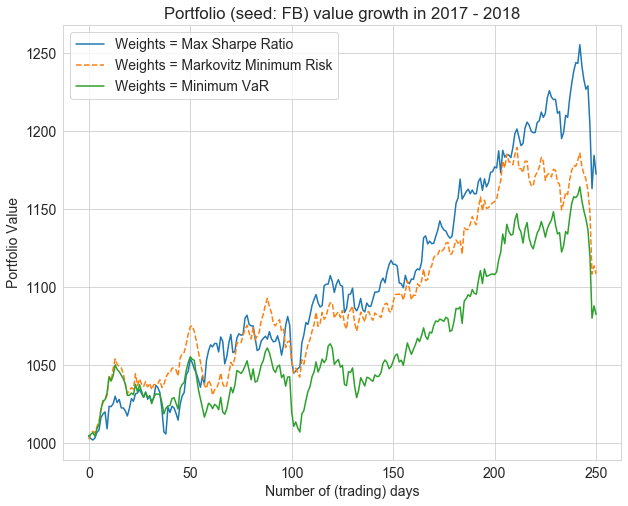

In [28]:
p_standard = future_returns(test_df, diverse_stocks, 1000)
p_optimized = future_returns(test_df, diverse_stocks, 1000, weights = max_sharpe[3:].tolist())
p_minrisk = future_returns(test_df, diverse_stocks, 1000, weights = min_risk[3:].tolist())
p_markovitz = future_returns(test_df, diverse_stocks, 1000, weights = w_min_var)
p_var = future_returns(test_df, diverse_stocks, 1000, weights = min_var[3:].tolist())

plt.figure(figsize = (10,8))

#plt.plot(list(p_minrisk.values()), label = 'Weights = Minimum Risk')
plt.plot(list(p_optimized.values()), label = 'Weights = Max Sharpe Ratio')
plt.plot(list(p_markovitz.values()), label = 'Weights = Markovitz Minimum Risk', ls = '--')
plt.plot(list(p_var.values()), label = 'Weights = Minimum VaR')

plt.legend()
plt.xlabel('Number of (trading) days')
plt.ylabel('Portfolio Value')
plt.title('Portfolio (seed: ' + seed_stock + ') value growth in 2017 - 2018')

#plt.savefig('final-LMT.jpg', dpi = 500, bbox_inches = 'tight')

plt.show()

Below we visualize how the returns of each stock in our portfolio are correlated (how scattered they are)

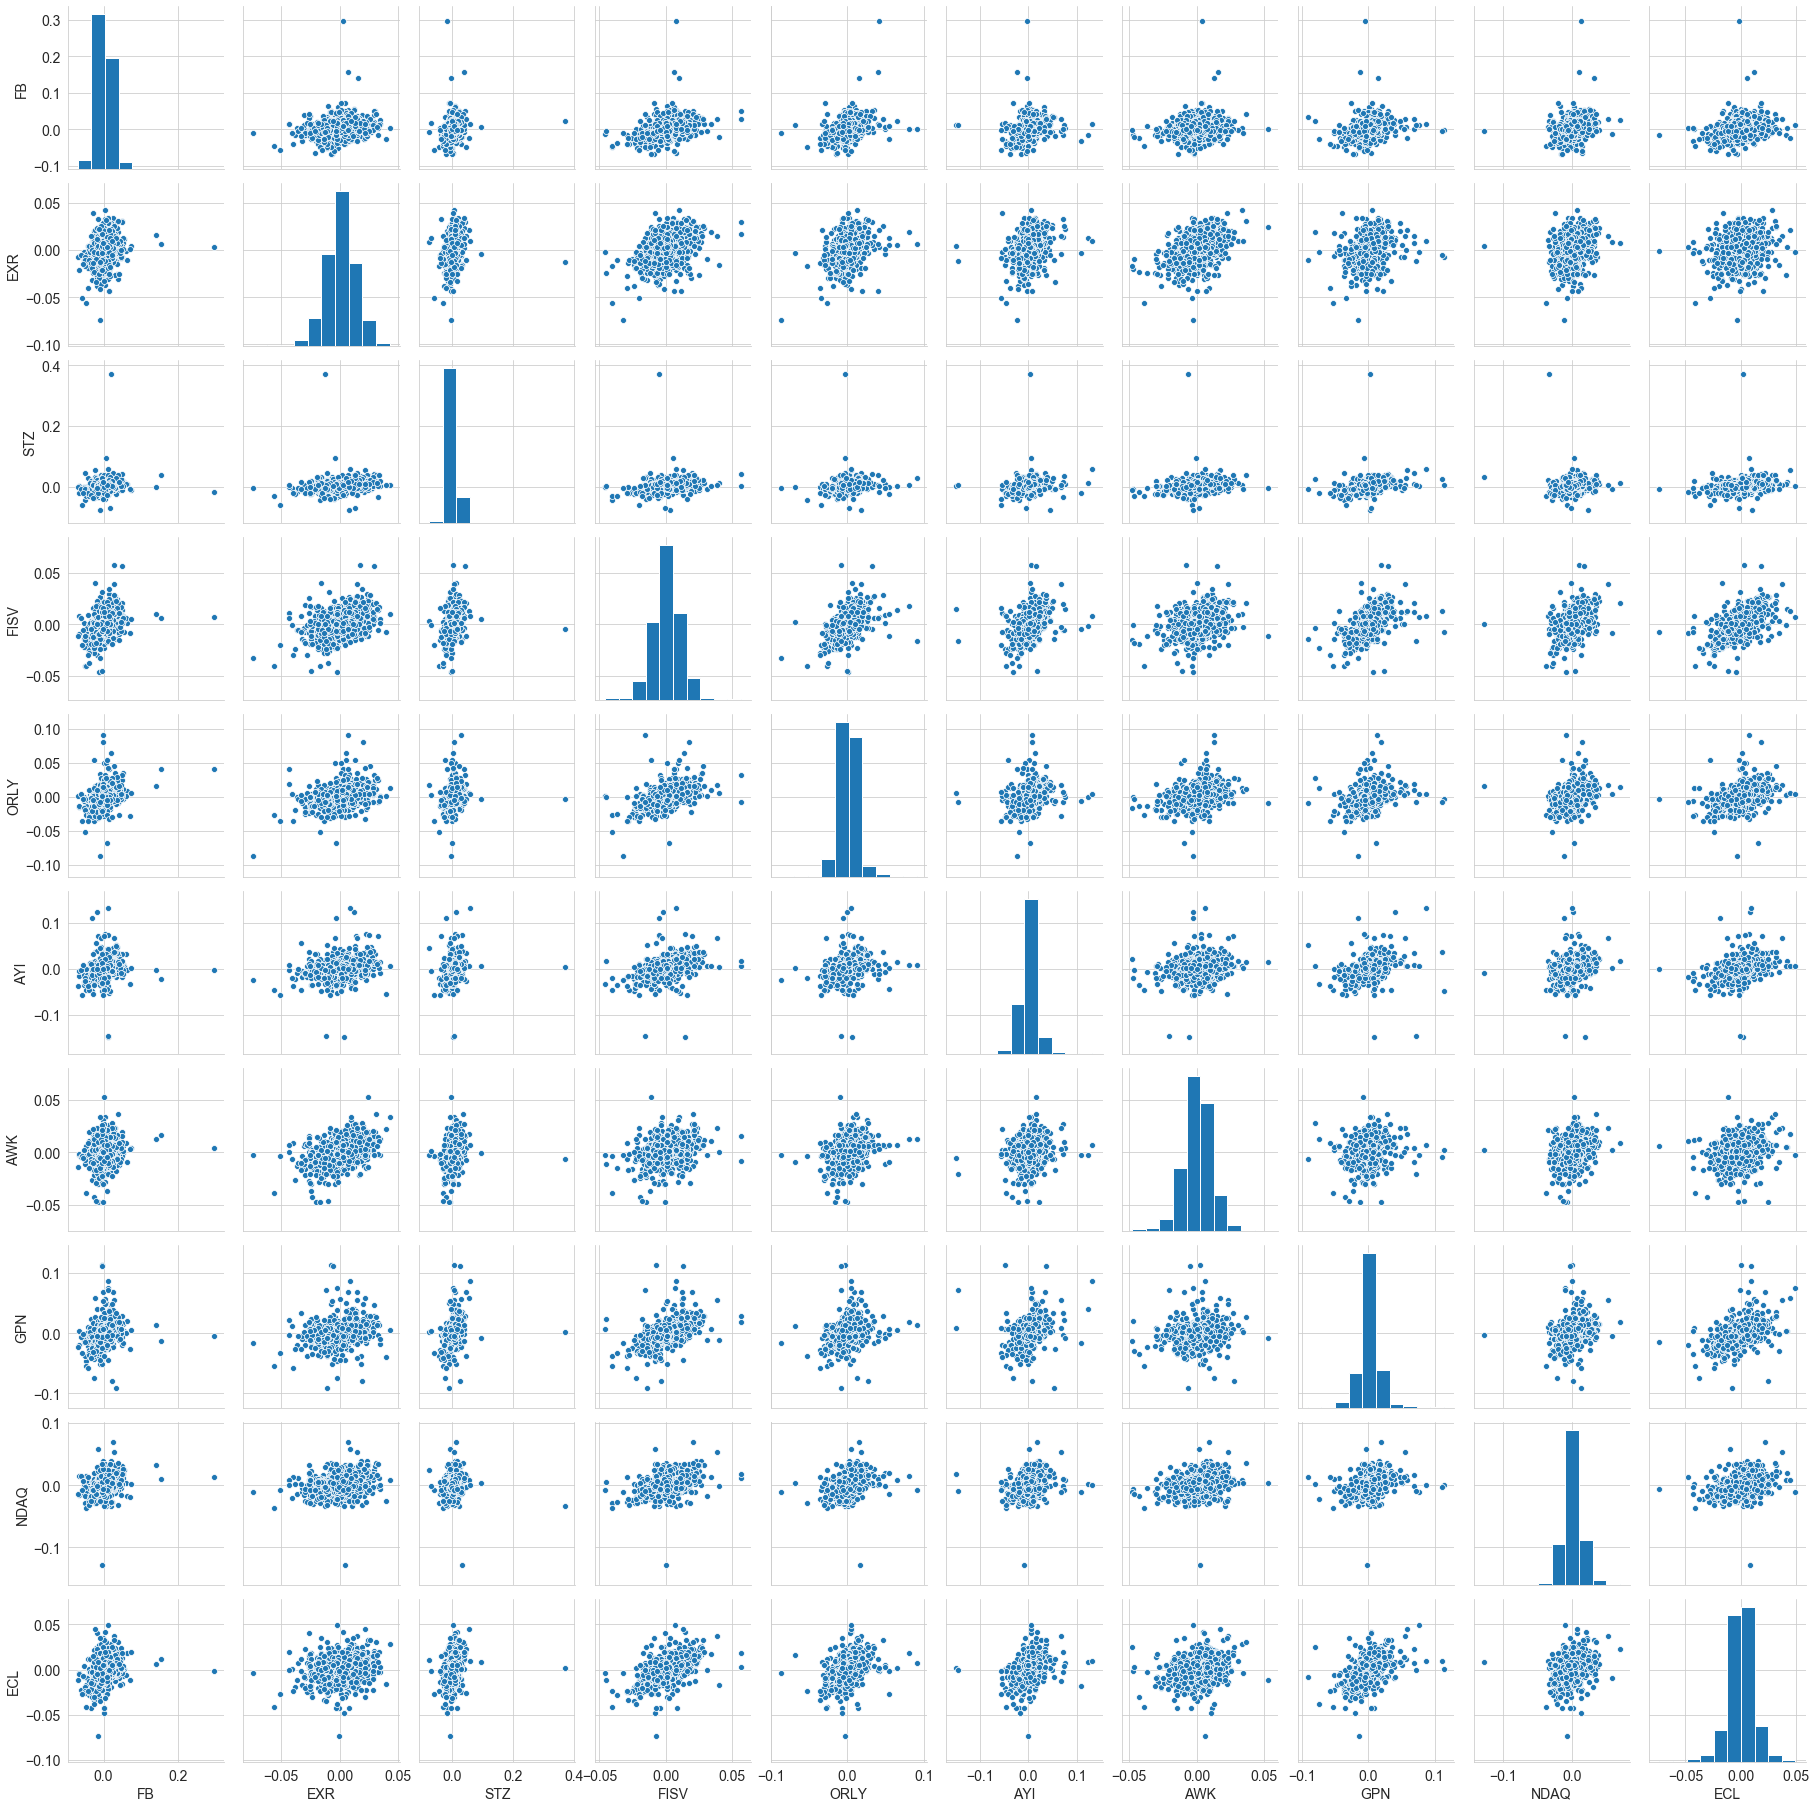

In [29]:
price_change_df = price_df[diverse_stocks].pct_change().dropna()
sns.pairplot(price_change_df)

(Looks pretty scattered!) There will always be some correlation between stocks as they're all part of the same macroeconomy.

For reference, here is what 2 highly correlated stocks look like: (Goldman and Morgan Stanley)

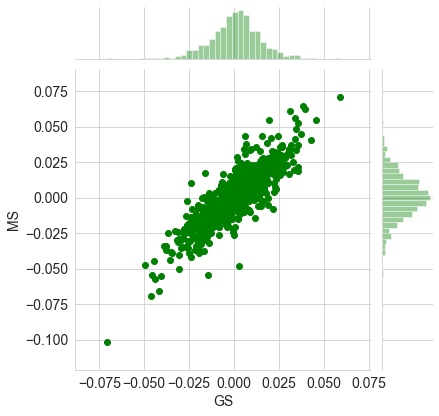

In [31]:
sns.jointplot(price_df['GS'].pct_change() , price_df['MS'].pct_change() , kind='scatter', color = 'green')